# Importing Libraries

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Importing Dataset

In [231]:
df = pd.read_csv('parkinsons_updrs.csv')

In [3]:
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

In [5]:
df.isnull().sum()

subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64

No null values found in the dataset

In [6]:
df.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,0.008962,0.034035,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,0.009371,0.025835,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,0.004730,0.019120,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,0.006750,0.027510,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,0.009870,0.039750,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


Here we can see a weird discrepancy in the data. The min value of "test_time" is negative. 

From the UCI ML Repository, the description of "test_time" is as follows: "Time since recruitment into the trial. The integer part is the number of days since recruitment."

How can that be negative for a patient?

In [221]:
df[df['test_time'] < 0].count()

subject#         12
age              12
sex              12
test_time        12
motor_UPDRS      12
total_UPDRS      12
Jitter(%)        12
Jitter(Abs)      12
Jitter:RAP       12
Jitter:PPQ5      12
Jitter:DDP       12
Shimmer          12
Shimmer(dB)      12
Shimmer:APQ3     12
Shimmer:APQ5     12
Shimmer:APQ11    12
Shimmer:DDA      12
NHR              12
HNR              12
RPDE             12
DFA              12
PPE              12
dtype: int64

We have 12 such entries that have a negative "test_time". It is better to drop these entries to avoid confusion for the models.

In [232]:
df = df[df['test_time'] > 0]

## Correlation Matrix

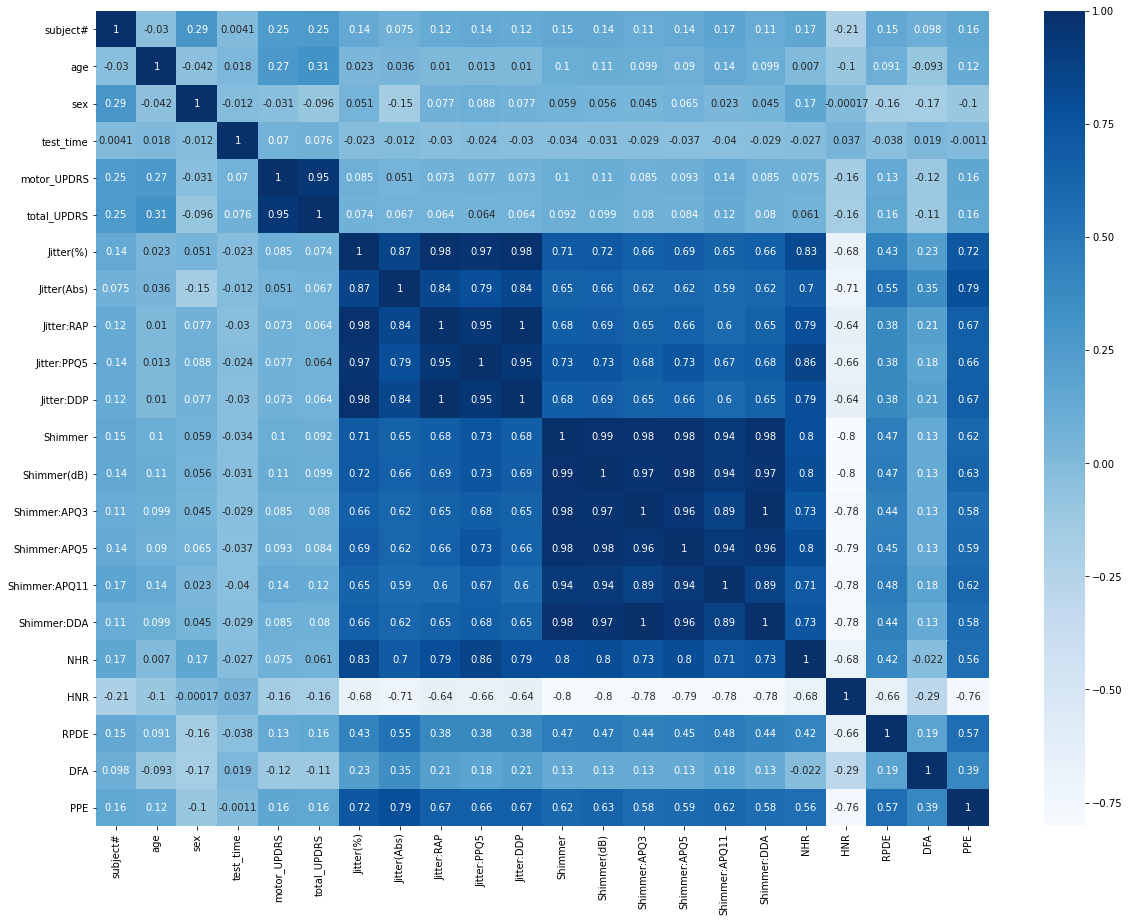

In [20]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, cmap='Blues')

As we can see, the data is highly correlated. Let us use Principal Component Analysis to narrow down the correlated features.

## PCA

In [51]:
data = df.copy()

Let us drop "subject#" from the dataset entirely as it not useful for our model. 

Let us also seperate the target variables before applying PCA.

In [52]:
data.drop(['subject#'], axis=1, inplace=True)

In [36]:
y1 = data['motor_UPDRS']
y2 = data['total_UPDRS']
data.drop(['motor_UPDRS', 'total_UPDRS'], axis=1, inplace=True)

## Splitting the data into Training and Test Set

In [54]:
x1_train, x1_test, y1_train, y1_test = train_test_split(data, y1, test_size=0.2, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(data, y2, test_size=0.2, random_state=42)

Let us first perform Standardization to the data before applying PCA. 

This will make every feature have a Standard Deviation of 1 and mean of 0.

I will use x1_train to perform PCA tests.

In [55]:
sc =  StandardScaler()
scaled_data = pd.DataFrame(sc.fit_transform(x1_train), columns=data.columns)

In [56]:
scaled_data.head()

,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,-0.773941,-0.685725,-0.040197,-1.033811,-1.313153,0.401620,0.611471,0.377309,0.522099,0.377288,0.579608,0.468792,0.775063,0.496052,0.317079,0.775068,0.154337,-1.459624,0.834924,1.581825,1.177734
1,1.271711,-0.685725,0.124754,1.078914,1.870205,-0.402102,-0.158845,-0.351485,-0.215892,-0.352578,-0.529551,-0.583921,-0.473490,-0.432491,-0.376939,-0.473735,-0.350487,-0.124628,0.807394,-0.574585,0.029718
2,2.294536,1.458310,-1.599231,-0.736380,-0.263322,0.268259,0.449418,0.319520,0.008714,0.318428,-0.033225,-0.096715,0.033192,0.042662,-0.008695,0.033449,-0.184314,-0.610060,0.776619,-0.079362,-0.763006
3,-1.114882,-0.685725,1.681591,-0.950515,-0.910125,-0.489231,-0.421472,-0.515223,-0.413759,-0.515246,-0.490326,-0.527371,-0.673137,-0.527401,-0.253525,-0.673130,-0.375835,0.613415,-0.283571,0.357592,-0.767768
4,0.817122,-0.685725,1.533871,1.932259,1.770474,-0.194059,-0.485500,-0.229484,-0.189153,-0.230577,-0.265465,-0.092365,-0.245861,-0.423423,-0.418910,-0.245855,-0.091116,0.626686,-0.067069,-0.827559,-0.404251


In [60]:
pca = PCA(n_components=8)
principal_components = pca.fit_transform(scaled_data)

In [61]:
pca_df = pd.DataFrame(principal_components, columns=['PCA1','PCA2','PCA3','PCA14','PCA5','PCA6','PCA7','PCA8',])

In [62]:
pca_df.head()

,PCA1,PCA2,PCA3,PCA14,PCA5,PCA6,PCA7,PCA8
0,2.340122,1.814710,-0.584392,-1.914913,0.163387,0.393219,-0.325763,-0.151898
1,-0.978973,-2.631182,-0.819175,-0.200685,-0.297657,-0.535935,0.265746,-0.595924
2,0.445891,0.087675,0.445554,0.350772,-1.825713,-1.949276,-1.584365,-0.685981
3,-2.043408,1.329038,-0.226226,-0.592821,1.784382,0.377174,0.676176,-0.119683
4,-0.999646,-2.916601,-0.354047,0.678863,1.256410,-0.148525,0.783858,0.112045


Plotting a Scree plot to perform the Elbow method to find the ideal components of PCA

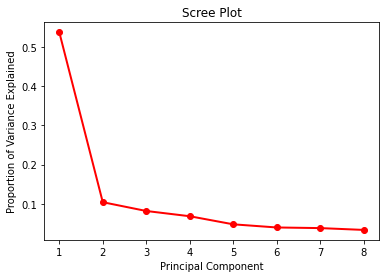

In [63]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

We also calculate the eigenvalues of the Principal Components and keep those components whoes Eigenvalues are greater than 1.

In [64]:
print(pca.explained_variance_)

[11.2824609   2.18375284  1.71295582  1.43203795  0.99934539  0.8306937
  0.79684069  0.69953293]


Hence we decide to keep 4 Principal Components.

Now we standardize all the training and test sets and perform PCA using 4 Principle Components.

In [65]:
sc1 = StandardScaler()
sc2 = StandardScaler()
x1_train = sc1.fit_transform(x1_train)
x1_test = sc1.transform(x1_test)

x2_train = sc2.fit_transform(x2_train)
x2_test = sc2.transform(x2_test)

The reason we seperated the data into training and test set so early is due avoid information leakage and overfitting of our model. 

The model should never have seen the test data to evaluate it's performance accurately.

In [67]:
pca1 = PCA(n_components=4)
pca2 = PCA(n_components=4)
x1_train = pca1.fit_transform(x1_train)
x1_test = pca1.transform(x1_test)

x2_train = pca2.fit_transform(x2_train)
x2_test = pca2.transform(x2_test)

Our data is ready to be fitted into Regression Models.

## Function for Evaluating Model Performance

In [71]:
def score(y_pred,y_test):
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)*100
    print("Mean Absolute Error: ", mae)
    print("Mean Squared Error: ", mse)
    print("R2 score: ", r2, "%")
    return (mae, mse, r2)

# Models

## Y1 Variabale: motor_UPDRS

### Linear Regression

In [73]:
lin_reg1 = LinearRegression()
lin_reg1.fit(x1_train, y1_train)
y_lin_pred1 = lin_reg1.predict(x1_test)

In [75]:
lin_mae1, lin_mse1, lin_r21 = score(y1_test,y_lin_pred1)

Mean Absolute Error:  2.013045997977355
Mean Squared Error:  6.628901362431444
R2 score:  88.7658976208952 %


### Polynomial Regression

In [92]:
poly = PolynomialFeatures(degree=3)
x1_poly = poly.fit_transform(x1_train)

In [93]:
poly_reg1 = LinearRegression()
poly_reg1.fit(x1_poly, y1_train)
y_poly_pred1 = poly_reg1.predict(poly.transform(x1_test))

In [95]:
poly_mae1, poly_mse1, poly_r21 = score(y1_test, y_poly_pred1)

Mean Absolute Error:  1.806287368888753
Mean Squared Error:  5.3075683826131606
R2 score:  91.24625229080422 %


### Support Vector Machine

In [102]:
svr_reg1 = SVR()
svr_reg1.fit(x1_train, y1_train)
y_svr_pred1 = svr_reg1.predict(x1_test)

In [103]:
svr_mae1, svr_mse1, svr_r21 = score(y1_test, y_svr_pred1)

Mean Absolute Error:  1.807060747073706
Mean Squared Error:  5.801616762630498
R2 score:  90.5366746680612 %


### Decision Tree Regression

In [105]:
dt_reg1 = DecisionTreeRegressor()
dt_reg1.fit(x1_train, y1_train)
y_dt_pred1 = dt_reg1.predict(x1_test)

In [106]:
dt_mae1, dt_mse1, dt_r21 = score(y1_test, y_dt_pred1)

Mean Absolute Error:  1.9060743108837737
Mean Squared Error:  7.887836194636734
R2 score:  88.11295332671143 %


### Random Forrest Regression

In [107]:
rf_reg1 = RandomForestRegressor()
rf_reg1.fit(x1_train, y1_train)
y_rf_pred1 = rf_reg1.predict(x1_test)

In [108]:
rf_mae1, rf_mse1, rf_r21 = score(y1_test, y_rf_pred1)

Mean Absolute Error:  1.5017740437373368
Mean Squared Error:  4.242023602073767
R2 score:  93.0950463901452 %


### XGBoost Regression

In [197]:
xgb_reg1 = XGBRegressor(objective='reg:squarederror')
xgb_reg1.fit(x1_train, y1_train)
y_xgb_pred1 = xgb_reg1.predict(x1_test)

In [112]:
xgb_mae1, xgb_mse1, xgb_r21 = score(y1_test, y_xgb_pred1)

Mean Absolute Error:  1.734105388724611
Mean Squared Error:  4.94686745690841
R2 score:  91.86002788248928 %


## Comparing Model1 Performance

In [115]:
model_mae1 = [lin_mae1,poly_mae1, svr_mae1, dt_mae1, rf_mae1, xgb_mae1]
model_mse1 = [lin_mse1,poly_mse1, svr_mse1, dt_mse1, rf_mse1, xgb_mse1]
model_r21 = [lin_r21,poly_r21, svr_r21, dt_r21, rf_r21, xgb_r21]
models=["Linear Regression", "Polynomial Regression", "SVM", "Decision Tree", "Random Forrest", "XGBoost"]

Text(0.5, 1.0, 'Comparing Model1 MAE(Test Set)')

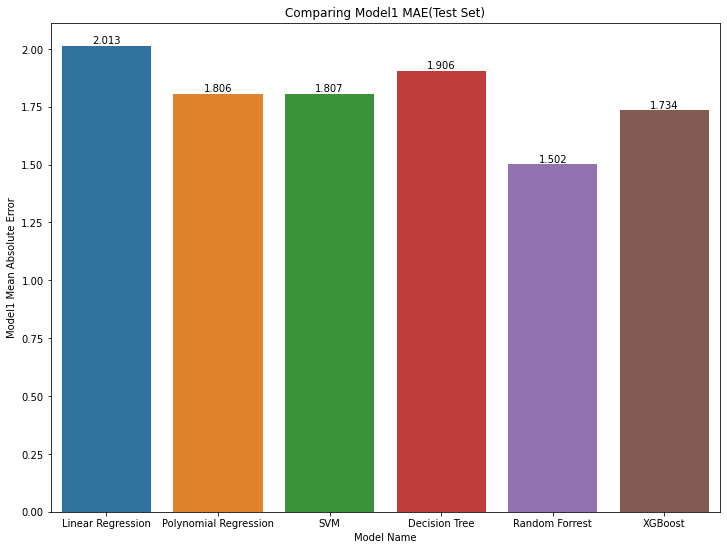

In [131]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_mae1)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.01,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model1 Mean Absolute Error')
plt.xlabel('Model Name')
plt.title('Comparing Model1 MAE(Test Set)')

Text(0.5, 1.0, 'Comparing Model1 MSE(Test Set)')

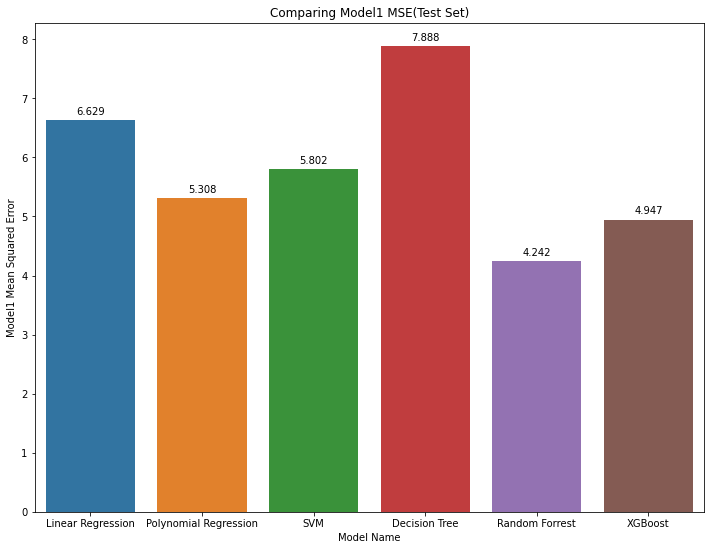

In [132]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_mse1)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.1,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model1 Mean Squared Error')
plt.xlabel('Model Name')
plt.title('Comparing Model1 MSE(Test Set)')

Text(0.5, 1.0, 'Comparing Model1 R2 Score(Test Set)')

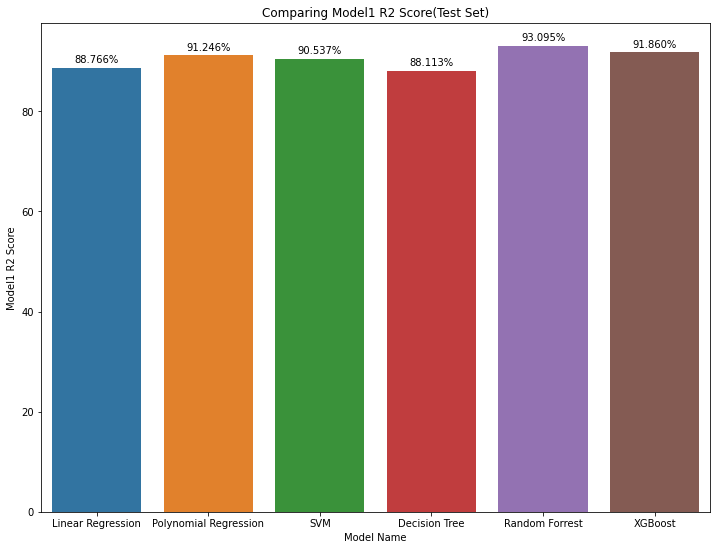

In [133]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_r21)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height + 1,
          '{:1.3f}%'.format(height),
          ha='center')
  
plt.ylabel('Model1 R2 Score')
plt.xlabel('Model Name')
plt.title('Comparing Model1 R2 Score(Test Set)')

### Performing Cross Validation for our 3 best performing models

#### R2 Score

In [207]:
poly_cv1 = cross_val_score(poly_reg1,x1_poly, y1_train, cv=10, scoring='r2')
rf_cv1 = cross_val_score(rf_reg1,x1_train, y1_train, cv=10, scoring='r2')
xgb_cv1 = cross_val_score(xgb_reg1,x1_train, y1_train, cv=10, scoring='r2')

In [208]:
print("Cross Validation Score for Polynomial Regression is: {:1.3f} +- {:1.3f}".format(poly_cv1.mean()*100, poly_cv1.std()*100))
print("Cross Validation Score for Random Forrest Regression is: {:1.3f} +- {:1.3f}".format(rf_cv1.mean()*100, rf_cv1.std()*100))
print("Cross Validation Score for XGBoost Model is: {:1.3f} +- {:1.3f}".format(xgb_cv1.mean()*100, xgb_cv1.std()*100))

Cross Validation Score for Polynomial Regression is: 90.463 +- 5.351
Cross Validation Score for Random Forrest Regression is: 93.518 +- 0.798
Cross Validation Score for XGBoost Model is: 92.739 +- 0.686


#### Thus Random Forrest Regression is the best model for Y1 Variable(motor_UPDRS) with a **MAE of 1.5 and R2 score of 93.1%**

## Y2 Variable: total_UPDRS

The Correlation Matrix gave us an interesting insight. "motor_UPDRS" and "total_UPDRS" are highly correlated(0.95).

In our current dataset, we already have the recorded data of "motor_UPDRS". But for future predictions, that might not be the case.

Hence we can use feature engineering to get a new highly correlated feature using our Model 1 for the "total_UPDRS" prediction.

We will use Random Forrest predictions as the new feature for our Model 2 as it was the best performing model.

### Adding the "motor_UPDRS" values predicted by our Model 1 to the second training and test set.

In [134]:
motor_train = rf_reg1.predict(x1_train)
motor_test = rf_reg1.predict(x1_test)

In [147]:
x2_train = pd.DataFrame(x2_train, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])

In [149]:
x2_test = pd.DataFrame(x2_test, columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4'])

In [158]:
x2_train['motor_UPDRS'] = motor_train

In [152]:
x2_test['motor_UPDRS'] = motor_test

Performing Standardization for the new feature we engineered.

In [159]:
ct = ColumnTransformer([('scaler', StandardScaler(), [4])], remainder='passthrough')
x2_train = np.array(ct.fit_transform(x2_train))
x2_test = np.array(ct.transform(x2_test))

### Linear Regression

In [162]:
lin_reg2 = LinearRegression()
lin_reg2.fit(x2_train, y2_train)
y_lin_pred2 = lin_reg2.predict(x2_test)

In [163]:
lin_mae2, lin_mse2, lin_r22 = score(y2_test,y_lin_pred2)

Mean Absolute Error:  2.1887633773514756
Mean Squared Error:  7.897445617969647
R2 score:  92.47253613847023 %


### Polynomial Regression

In [178]:
poly2 = PolynomialFeatures(degree=3)
x2_poly = poly2.fit_transform(x2_train)

In [179]:
poly_reg2 = LinearRegression()
poly_reg2.fit(x2_poly, y2_train)
y_poly_pred2 = poly_reg2.predict(poly2.transform(x2_test))

In [180]:
poly_mae2, poly_mse2, poly_r22 = score(y2_test, y_poly_pred2)

Mean Absolute Error:  2.0191681934879133
Mean Squared Error:  6.865629099848786
R2 score:  93.5804043349027 %


### Support Vector Machines

In [181]:
svr_reg2 = SVR()
svr_reg2.fit(x2_train, y2_train)
y_svr_pred2 = svr_reg2.predict(x2_test)

In [182]:
svr_mae2, svr_mse2, svr_r22 = score(y2_test, y_svr_pred2)

Mean Absolute Error:  1.9743432264007872
Mean Squared Error:  6.803789580012781
R2 score:  93.34567645741238 %


### Decision Tree Regression

In [183]:
dt_reg2 = DecisionTreeRegressor()
dt_reg2.fit(x2_train, y2_train)
y_dt_pred2 = dt_reg2.predict(x2_test)

In [184]:
dt_mae2, dt_mse2, dt_r22 = score(y2_test, y_dt_pred2)

Mean Absolute Error:  1.8557975845410626
Mean Squared Error:  7.791706275283224
R2 score:  93.13552893950458 %


### Random Forrest Regression

In [185]:
rf_reg2 = RandomForestRegressor()
rf_reg2.fit(x2_train, y2_train)
y_rf_pred2 = rf_reg2.predict(x2_test)

In [186]:
rf_mae2, rf_mse2, rf_r22 = score(y2_test, y_rf_pred2)

Mean Absolute Error:  1.6501308562341583
Mean Squared Error:  5.545603335538609
R2 score:  95.02817568287286 %


### XGBoost Regression

In [210]:
xgb_reg2 = XGBRegressor(objective='reg:squarederror')
xgb_reg2.fit(x2_train, y2_train)
y_xgb_pred2 = xgb_reg2.predict(x2_test)

In [188]:
xgb_mae2, xgb_mse2, xgb_r22 = score(y2_test, y_xgb_pred2)

Mean Absolute Error:  1.8405141578316588
Mean Squared Error:  5.781456617119022
R2 score:  94.67397057210276 %


## Comparing Model2 Performance

In [189]:
model_mae2 = [lin_mae2,poly_mae2, svr_mae2, dt_mae2, rf_mae2, xgb_mae2]
model_mse2 = [lin_mse2,poly_mse2, svr_mse2, dt_mse2, rf_mse2, xgb_mse2]
model_r22 = [lin_r22,poly_r22, svr_r22, dt_r22, rf_r22, xgb_r22]

Text(0.5, 1.0, 'Comparing Model2 MAE(Test Set)')

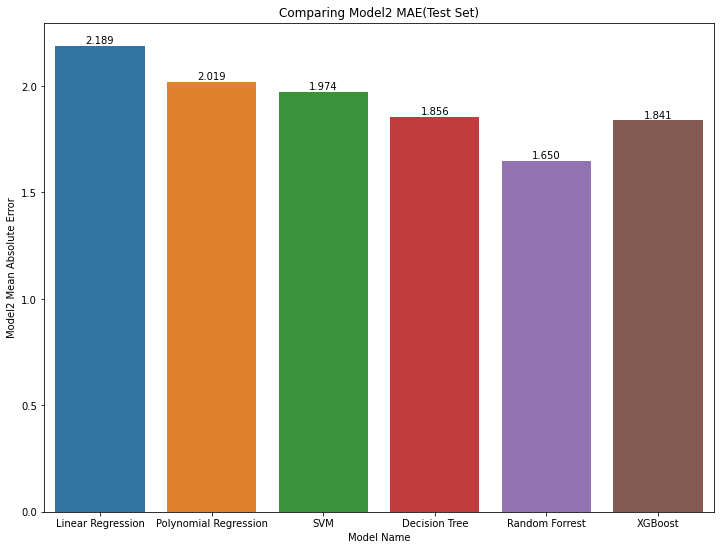

In [190]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_mae2)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.01,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model2 Mean Absolute Error')
plt.xlabel('Model Name')
plt.title('Comparing Model2 MAE(Test Set)')

Text(0.5, 1.0, 'Comparing Model2 MSE(Test Set)')

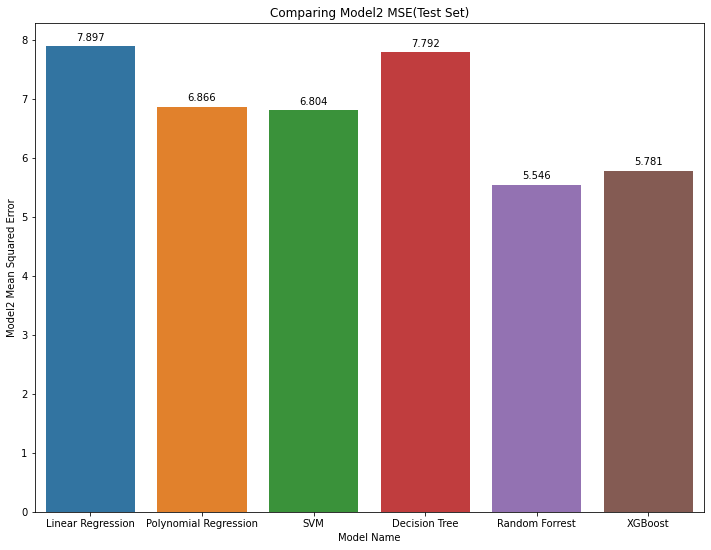

In [191]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_mse2)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.1,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model2 Mean Squared Error')
plt.xlabel('Model Name')
plt.title('Comparing Model2 MSE(Test Set)')

Text(0.5, 1.0, 'Comparing Model2 R2 Score(Test Set)')

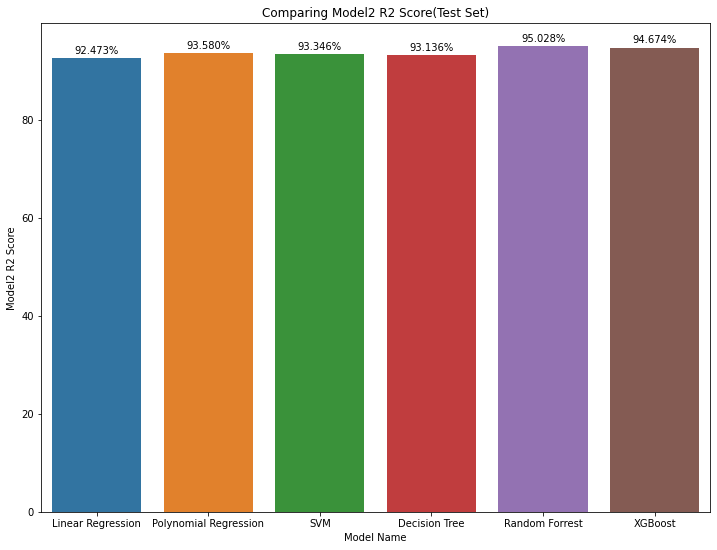

In [192]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_r22)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height + 1,
          '{:1.3f}%'.format(height),
          ha='center')
  
plt.ylabel('Model2 R2 Score')
plt.xlabel('Model Name')
plt.title('Comparing Model2 R2 Score(Test Set)')

### Performing Cross Validation for our 3 best performing models

In [211]:
svr_cv2 = cross_val_score(svr_reg2,x2_train, y2_train, cv=10, scoring='r2')
rf_cv2 = cross_val_score(rf_reg2,x2_train, y2_train, cv=10, scoring='r2')
xgb_cv2 = cross_val_score(xgb_reg2,x2_train, y2_train, cv=10, scoring='r2')

In [212]:
print("Cross Validation Score for Support Vector Regression is: {:1.3f} +- {:1.3f}".format(svr_cv2.mean()*100, svr_cv2.std()*100))
print("Cross Validation Score for Random Forrest Regression is: {:1.3f} +- {:1.3f}".format(rf_cv2.mean()*100, rf_cv2.std()*100))
print("Cross Validation Score for XGBoost Model is: {:1.3f} +- {:1.3f}".format(xgb_cv2.mean()*100, xgb_cv2.std()*100))

Cross Validation Score for Support Vector Regression is: 94.037 +- 0.620
Cross Validation Score for Random Forrest Regression is: 97.726 +- 0.252
Cross Validation Score for XGBoost Model is: 96.468 +- 0.146


#### Thus Random Forrest Regressionis is the best model for Y2 Variable(total_UPDRS) with a **MAE of 1.65 and R2 score of 95.02%**

# Deep Learning Approach

In [233]:
df.drop(['subject#'], axis=1, inplace=True)

In [234]:
df.head()

,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [235]:
y = df.iloc[:, [3,4]].values

In [237]:
df.drop(['motor_UPDRS', 'total_UPDRS'], axis=1, inplace=True)

In [238]:
x = df.values

### Splitting data into Training and Test set

In [240]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

### Standardizing so that the Standard deviation is 1 and mean is 0 for all features.

In [241]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

### Artificial Neural Network

In [266]:
ann1 = Sequential([
                   Dense(units=128, activation='relu'),
                   Dense(units=64, activation='relu'),
                   Dense(units=32, activation='relu'),
                   Dense(units=16, activation='relu'),
                   Dense(units=2)
])

In [267]:
ann1.compile(optimizer='adam', loss="mean_absolute_error")

In [268]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<1.5):
            print("\nReached 1.5 MAE so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

In [269]:
r1 = ann1.fit(x_train, y_train,
              validation_data=(x_test, y_test), batch_size=32, epochs=500, callbacks=[callback])

Epoch 1/500
147/147 [==============================] - 1s 4ms/step - loss: 13.2879 - val_loss: 8.0399
Epoch 2/500
147/147 [==============================] - 0s 3ms/step - loss: 7.2379 - val_loss: 7.2201
Epoch 3/500
147/147 [==============================] - 0s 3ms/step - loss: 6.6787 - val_loss: 6.7628
Epoch 4/500
147/147 [==============================] - 0s 3ms/step - loss: 6.2049 - val_loss: 6.2293
Epoch 5/500
147/147 [==============================] - 0s 3ms/step - loss: 5.6884 - val_loss: 5.6670
Epoch 6/500
147/147 [==============================] - 0s 2ms/step - loss: 5.3770 - val_loss: 5.4989
Epoch 7/500
147/147 [==============================] - 0s 2ms/step - loss: 5.2140 - val_loss: 5.3785
Epoch 8/500
147/147 [==============================] - 0s 2ms/step - loss: 4.9891 - val_loss: 5.0751
Epoch 9/500
147/147 [==============================] - 0s 2ms/step - loss: 4.8439 - val_loss: 4.9921
Epoch 10/500
147/147 [==============================] - 0s 2ms/step - loss: 4.6806 - val_l

In [276]:
ann1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               2560      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 34        
Total params: 13,458
Trainable params: 13,458
Non-trainable params: 0
_________________________________________________________________


In [275]:
ann_mae = ann1.evaluate(x_test, y_test)

37/37 [==============================] - 0s 1ms/step - loss: 1.7732


Our Neural Network gave us a **MAE of 1.7732**

We are getting a MAE of 1.7732 which is very close to our MAE of Random Forrest Regression (1.502 for Y1 Variable and 1.650 for Y2 Variable) using Feature Engineering. 

Text(0.5, 1.0, 'Comparing Neural Network MAE to Random Forrest MAE')

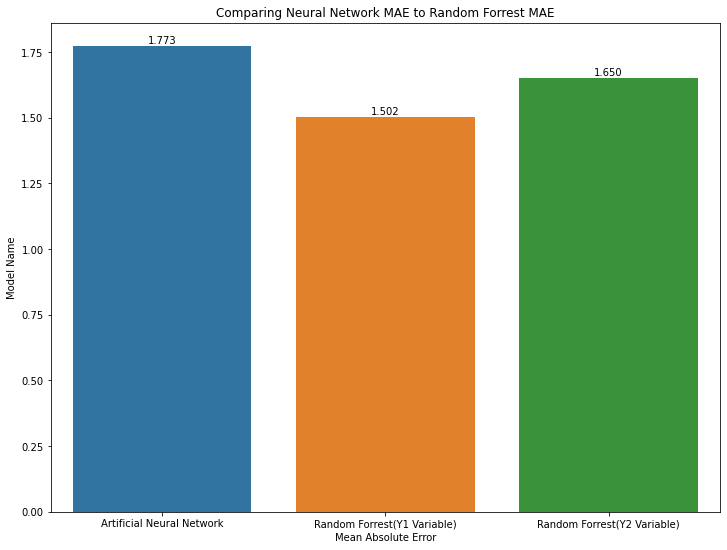

In [283]:
plt.figure(figsize=(12,9))
ax = sns.barplot(y=[ann_mae, rf_mae1, rf_mae2], x=['Artificial Neural Network', 'Random Forrest(Y1 Variable)', 'Random Forrest(Y2 Variable)'])
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height + 0.01,
          '{:1.3f}'.format(height),
          ha='center')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Model Name')
plt.title('Comparing Neural Network MAE to Random Forrest MAE')